In [1]:
%pip install -q optuna

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import optuna
import matplotlib.pyplot as plt
from helper_functions import backtesting

# In-sample Data


In [3]:
train_data = pd.read_csv('train_data.csv', index_col=0).dropna()
train_data['datetime'] = pd.to_datetime(train_data['datetime'])
train_data

#Set index starting from 0
train_data.index = range(len(train_data))

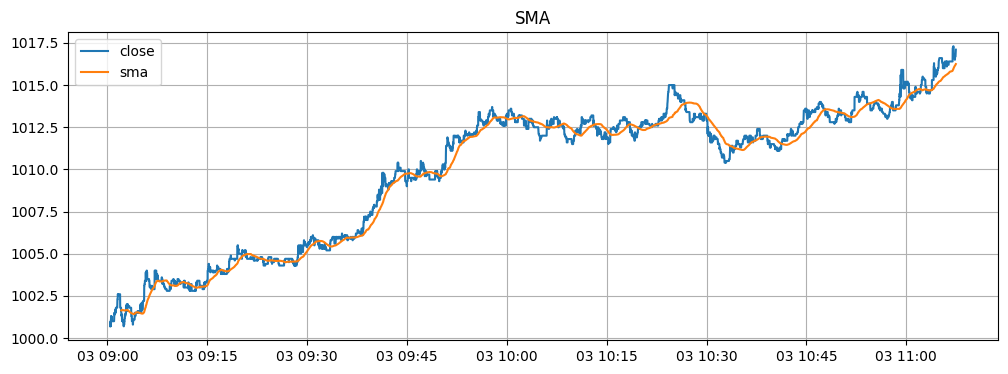

In [4]:
SMA_WINDOW_LENGTH = 100
train_data['SMA'] = train_data['Price'].rolling(SMA_WINDOW_LENGTH).mean()

plotting_data = train_data.iloc[:5000]
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(plotting_data["datetime"], plotting_data["Price"], label="close")
ax.plot(plotting_data["datetime"], plotting_data["SMA"], label="sma")

plt.title("SMA")
plt.legend()
plt.grid(True)
plt.show()

# Backtesting

In [5]:
# initial asset value in cash
asset_value = 1000

In [6]:
from helper_functions import backtesting
backtest_data = backtesting(train_data, 0.003, 0.5, 2, 1, 150, 120, 240, 60)
backtest_data

100%|██████████| 1793153/1793153 [00:36<00:00, 48489.37it/s]


,datetime,Price,weighted_bid,weighted_ask,imbalance,SMA,price/sma,EMA_short_window,EMA_long_window,MACD,signal_line,Asset,PNL,Cumulative PNL,Position,Entry Price
0,2023-01-03 09:00:26.440263,1000.7,45.1,6.2,0.758285,NaN,NaN,1000.700000,1000.700000,0.000000,0.000000,1000.00,0.0,0.00,None,None
1,2023-01-03 09:00:27.498407,1000.7,35.6,6.1,0.707434,NaN,NaN,1000.700000,1000.700000,0.000000,0.000000,1000.00,0.0,0.00,None,None
2,2023-01-03 09:00:28.037955,1001.0,18.8,5.7,0.534694,NaN,NaN,1000.801671,1000.800834,0.000837,0.000288,1000.00,0.0,0.00,LONG,1001.0
3,2023-01-03 09:00:28.923597,1001.0,30.4,17.3,0.274633,NaN,NaN,1000.852500,1000.851250,0.001250,0.000541,1000.00,0.0,0.00,None,None
4,2023-01-03 09:00:29.098069,1000.7,9.6,37.9,-0.595789,NaN,NaN,1000.820975,1000.820494,0.000481,0.000528,1000.00,0.0,0.00,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1793148,2023-12-29 14:29:52.292383,1133.9,62.2,22.5,0.468713,1133.402667,1.000439,1133.584145,1133.495942,0.088203,0.006121,439.61,0.0,-560.39,None,None
1793149,2023-12-29 14:29:54.320223,1133.9,54.0,33.0,0.241379,1133.409333,1.000433,1133.589365,1133.499295,0.090070,0.008874,439.61,0.0,-560.39,None,None
1793150,2023-12-29 14:29:55.333694,1134.3,54.0,33.0,0.241379,1133.418000,1.000778,1133.601111,1133.505940,0.095172,0.011703,439.61,0.0,-560.39,None,None
1793151,2023-12-29 14:29:57.149751,1134.3,22.2,26.0,-0.078838,1133.426667,1.000771,1133.612663,1133.512530,0.100134,0.014602,439.61,0.0,-560.39,None,None


In [7]:
backtest_data.dtypes

datetime            datetime64[ns]
Price                      float64
weighted_bid               float64
weighted_ask               float64
imbalance                  float64
SMA                        float64
price/sma                  float64
EMA_short_window           float64
EMA_long_window            float64
MACD                       float64
signal_line                float64
Asset                      float64
PNL                        float64
Cumulative PNL             float64
Position                    object
Entry Price                 object
dtype: object

## Cummulative PNL

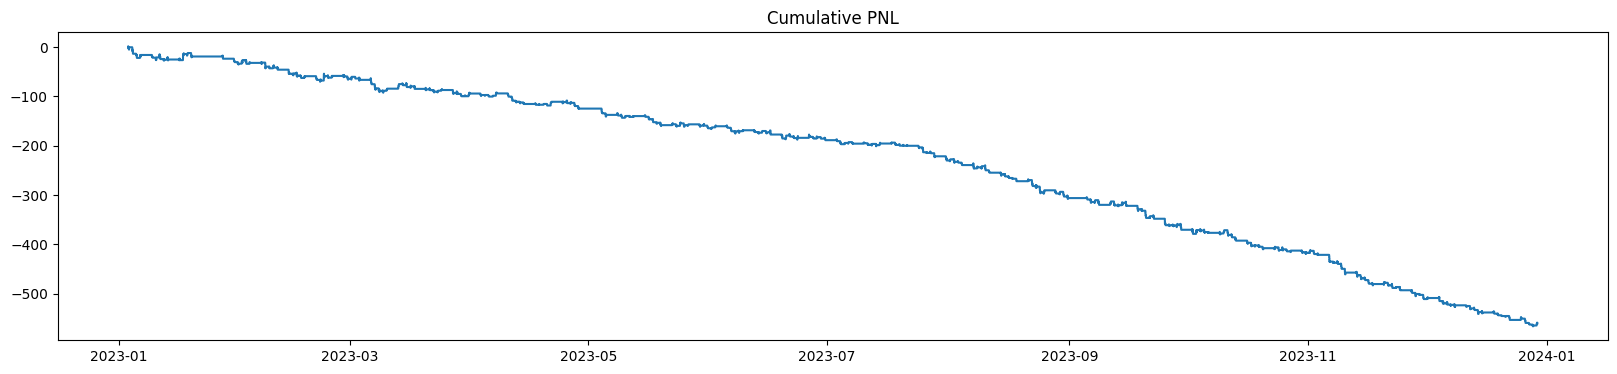

In [8]:
# plot asset value over time
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(backtest_data["datetime"], backtest_data["Cumulative PNL"])
plt.title("Cumulative PNL")
plt.show()

## Max Drawdown

In [9]:
# for each day, calculate the peak of asset value since inception
backtest_data['peak'] = backtest_data['Asset'].cummax()

# for each day, calculate asset drawdown
backtest_data['drawdown'] = backtest_data['Asset']/backtest_data['peak'] - 1

# max drawdown is the most negative value
mdd = backtest_data['drawdown'].min() * 100

In [10]:
mdd

np.float64(-56.68460409532854)

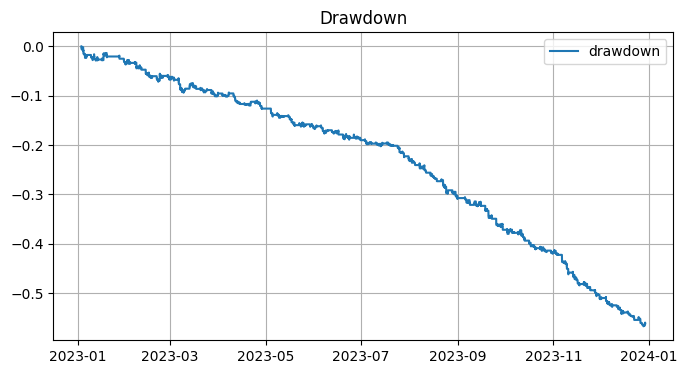

In [11]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(backtest_data["datetime"], backtest_data["drawdown"], label="drawdown")

plt.title('Drawdown')
plt.grid(True)
plt.legend()
plt.show()

## Sharpe Ratio

In [12]:
trade_return = backtest_data['Asset'][1:].to_numpy(
) / backtest_data['Asset'][:-1].to_numpy() - 1
cur_asset_value = backtest_data['Asset'].iloc[-1]
init_asset_value = backtest_data['Asset'].iloc[0]

accum_return_rate = (cur_asset_value / init_asset_value - 1) * 100
accum_return_rate

trade_return = np.array(trade_return)  # Ensure trade_return is a NumPy array
risk_free_rate_annual = 0.03  # Annual risk-free rate (e.g., government bonds interest is 3%)
number_of_trades = len(trade_return)
day_of_insample_data = 252 # Number of trading days in sample data
month_of_insample_data = 12  # Number of months in sample data

# Calculate annualized return
annually_return = accum_return_rate / (month_of_insample_data*100) * 12

# Calculate annualized volatility
annually_std = trade_return.std() * np.sqrt(number_of_trades)

# Calculate Sharpe Ratio
sharpe = (annually_return - risk_free_rate_annual) / annually_std

annually_return, annually_std, sharpe

(np.float64(-0.5603900000000392),
 np.float64(0.09516605307875485),
 np.float64(-6.203787809834468))

# Optimization

In [13]:
import optuna
def Objective(trial):
    # price_sma_gap = trial.suggest_float('price_sma_gap', 0.0001, 0.01)
    imbalance = trial.suggest_float('imbalance', 0.1, 1)
    take_profit_threshold = trial.suggest_float('take_profit_threshold', 0.9, 4)
    cut_loss_threshold = trial.suggest_float('cut_loss_threshold', 0.4, 3)
    # sma_window_length = trial.suggest_int('sma_window_length', 100, 5000)
    short_window = trial.suggest_int('short_window', 30, 300)  
    long_window = trial.suggest_int('long_window', 60, 800)
    signal_window = trial.suggest_int('signal_window', 10, 200)
     
    data = backtesting(train_data, 0, imbalance,
                       take_profit_threshold, cut_loss_threshold, 0, short_window, long_window, signal_window)
    return data.iloc[-1]["Cumulative PNL"]

In [14]:
sampler = optuna.samplers.TPESampler(seed=43)
study = optuna.create_study(study_name='sma-v2', storage='sqlite:///sma.db', load_if_exists=True, sampler=sampler, direction="maximize")
study.optimize(Objective, n_trials = 2000)

[I 2025-02-19 16:25:36,289] Using an existing study with name 'sma-v2' instead of creating a new one.
 20%|██        | 365865/1793153 [00:08<00:34, 40881.84it/s]
[W 2025-02-19 16:25:47,795] Trial 4762 failed with parameters: {'imbalance': 0.11280898603892923, 'take_profit_threshold': 3.980972457376429, 'cut_loss_threshold': 1.243454052627966, 'short_window': 43, 'long_window': 711, 'signal_window': 24} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\strnam\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\strnam\AppData\Local\Temp\ipykernel_8784\1799572465.py", line 12, in Objective
    data = backtesting(train_data, 0, imbalance,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\strnam\OneDrive\Phương Linh\Algotrade\TA final\helper_functions.py", line 201, in backtesting

KeyboardInterrupt: 

In [ ]:
study.best_params

ValueError: Record does not exist.

In [ ]:
# save the best parameters to json file
import json
with open('best_params.json', 'w') as f:
    json.dump(study.best_params, f)

In [ ]:
params = study.best_params
optimized_backtest_data = backtesting(train_data, params['price_sma_gap'], params['imbalance'],
                   params['take_profit_threshold'], params['cut_loss_threshold'], params['sma_window_length'])

optimized_backtest_data

100%|██████████| 1793153/1793153 [00:05<00:00, 340862.36it/s]


,datetime,Price,weighted_bid,weighted_ask,imbalance,SMA,price/sma,Asset,PNL,Cumulative PNL,Position,Entry Price
11,2023-01-03 09:00:26.440263,1000.7,45.1,6.2,0.758285,NaN,NaN,1000.00,0.0,0.00,None,None
12,2023-01-03 09:00:27.498407,1000.7,35.6,6.1,0.707434,NaN,NaN,1000.00,0.0,0.00,None,None
13,2023-01-03 09:00:28.037955,1001.0,18.8,5.7,0.534694,NaN,NaN,1000.00,0.0,0.00,None,None
14,2023-01-03 09:00:28.923597,1001.0,30.4,17.3,0.274633,NaN,NaN,1000.00,0.0,0.00,None,None
15,2023-01-03 09:00:29.098069,1000.7,9.6,37.9,-0.595789,NaN,NaN,1000.00,0.0,0.00,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...
1793159,2023-12-29 14:29:52.292383,1133.9,62.2,22.5,0.468713,1133.786111,1.000100,2760.71,0.0,1760.71,None,None
1793160,2023-12-29 14:29:54.320223,1133.9,54.0,33.0,0.241379,1133.780556,1.000105,2760.71,0.0,1760.71,None,None
1793161,2023-12-29 14:29:55.333694,1134.3,54.0,33.0,0.241379,1133.791667,1.000448,2760.71,0.0,1760.71,None,None
1793162,2023-12-29 14:29:57.149751,1134.3,22.2,26.0,-0.078838,1133.805556,1.000436,2760.71,0.0,1760.71,None,None


## Total win/lost by months

In [ ]:
import matplotlib.pyplot as plt

monthly_pnl = optimized_backtest_data.copy()
monthly_pnl['PNL_positive'] = monthly_pnl['PNL'].apply(
    lambda x: x if x > 0 else 0)
monthly_pnl['PNL_negative'] = monthly_pnl['PNL'].apply(
    lambda x: x if x < 0 else 0)
monthly_pnl = monthly_pnl.resample('ME', on='datetime').sum()

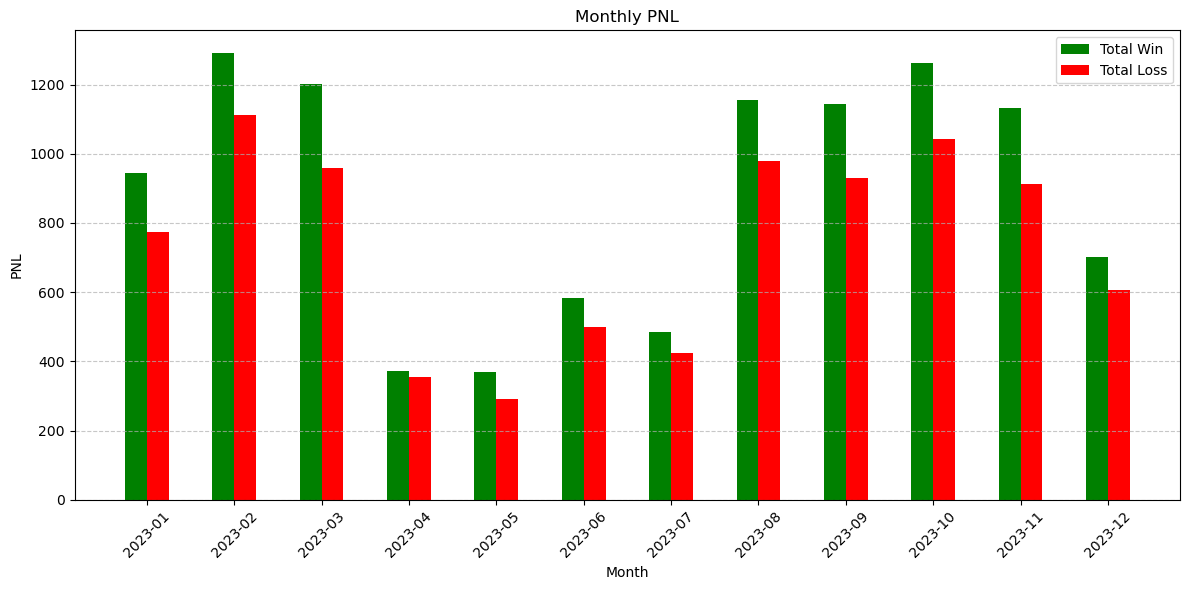

In [ ]:
# Bar width and positions
bar_width = 0.25  # Adjust for spacing
index = np.arange(len(monthly_pnl.index))

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(index - bar_width / 2,
       monthly_pnl['PNL_positive'], bar_width, color='g', label='Total Win')
ax.bar(index + bar_width / 2,
       monthly_pnl['PNL_negative'].abs(), bar_width, color='r', label='Total Loss')

# Adjust x-axis labels
ax.set_xticks(index)
ax.set_xticklabels(monthly_pnl.index.strftime('%Y-%m'), rotation=45)

plt.title('Monthly PNL')
plt.xlabel('Month')
plt.ylabel('PNL')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
monthly_pnl = optimized_backtest_data.copy()
monthly_pnl['PNL_positive'] = monthly_pnl['PNL'].apply(
    lambda x: 1 if x > 0 else 0)
monthly_pnl['PNL_negative'] = monthly_pnl['PNL'].apply(
    lambda x: 1 if x < 0 else 0)
monthly_pnl = monthly_pnl.resample('ME', on='datetime').sum()

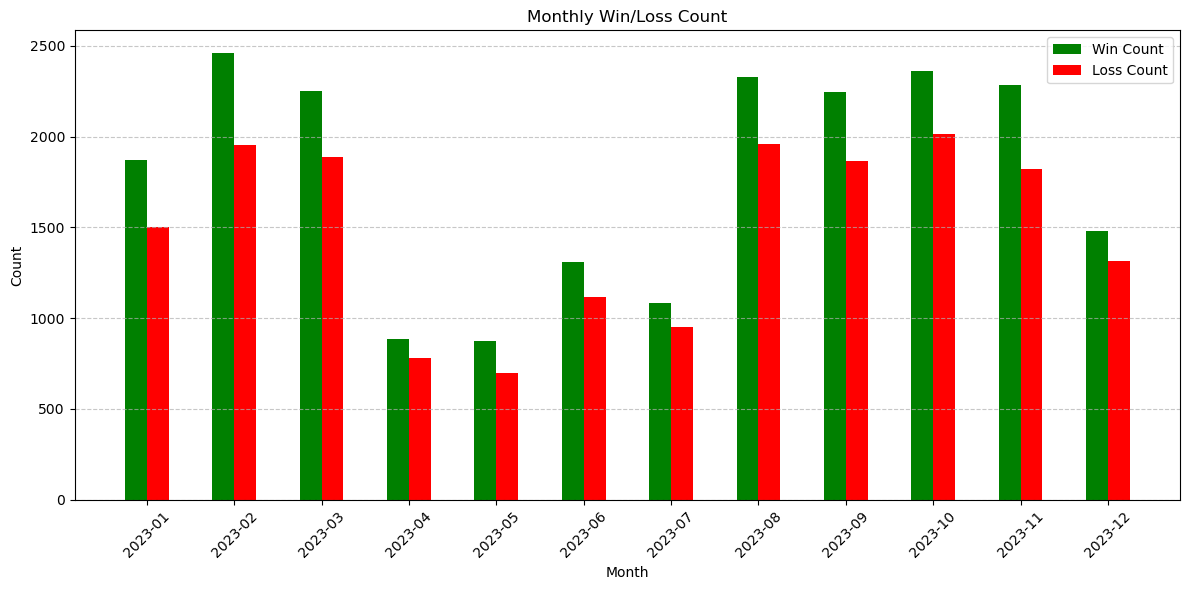

In [ ]:
# Bar width and positions
bar_width = 0.25  # Adjust for spacing
index = np.arange(len(monthly_pnl.index))

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(index - bar_width / 2,
       monthly_pnl['PNL_positive'], bar_width, color='g', label='Win Count')
ax.bar(index + bar_width / 2,
       monthly_pnl['PNL_negative'], bar_width, color='r', label='Loss Count')

# Adjust x-axis labels
ax.set_xticks(index)
ax.set_xticklabels(monthly_pnl.index.strftime('%Y-%m'), rotation=45)

plt.title('Monthly Win/Loss Count')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [ ]:
# total win count
total_win = monthly_pnl['PNL_positive'].sum()
# total loss count
total_loss = monthly_pnl['PNL_negative'].sum()

# total win rate
total_win_rate = total_win / (total_win + total_loss)
# total loss rate
total_loss_rate = total_loss / (total_win + total_loss)

print(f"Total Win Count: {total_win}")
print(f"Total Loss Count: {total_loss}")
print(f"Total Win Rate: {total_win_rate * 100:.2f}%")
print(f"Total Loss Rate: {total_loss_rate * 100:.2f}%")

Total Win Count: 21441
Total Loss Count: 17853
Total Win Rate: 54.57%
Total Loss Rate: 45.43%


## Cumulative PNL

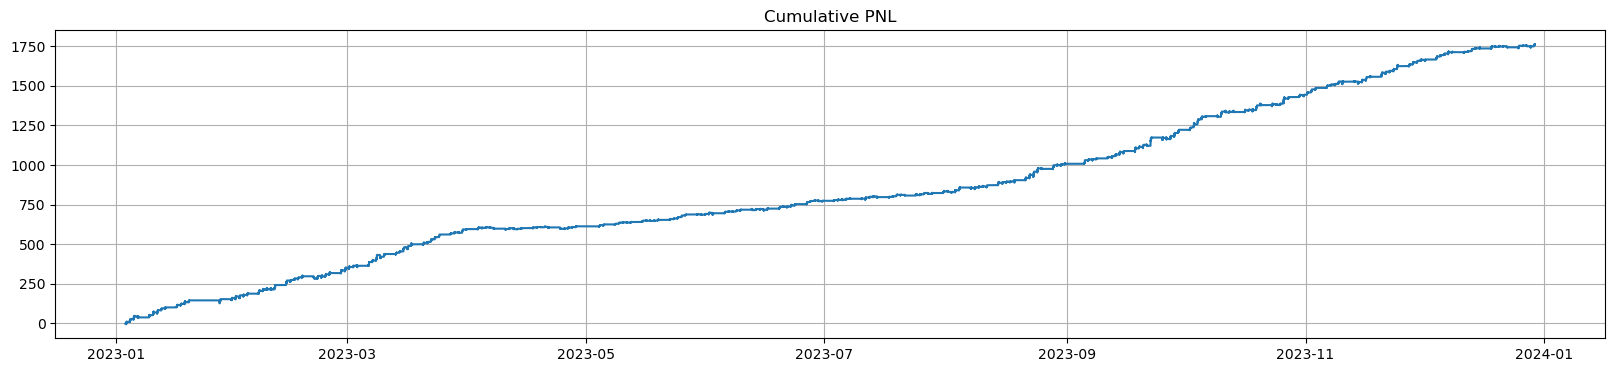

In [ ]:
# plot asset value over time
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(optimized_backtest_data["datetime"], optimized_backtest_data["Cumulative PNL"])

plt.title("Cumulative PNL")
plt.grid(True)
plt.show()

## Max Drawdown

In [ ]:
# for each day, calculate the peak of asset value since inception
optimized_backtest_data['peak'] = optimized_backtest_data['Asset'].cummax()

# for each day, calculate asset drawdown
optimized_backtest_data['drawdown'] = optimized_backtest_data['Asset'] / \
    optimized_backtest_data['peak'] - 1

# max drawdown is the most negative value
mdd = optimized_backtest_data['drawdown'].min() * 100

In [ ]:
mdd

-1.6459756070956844

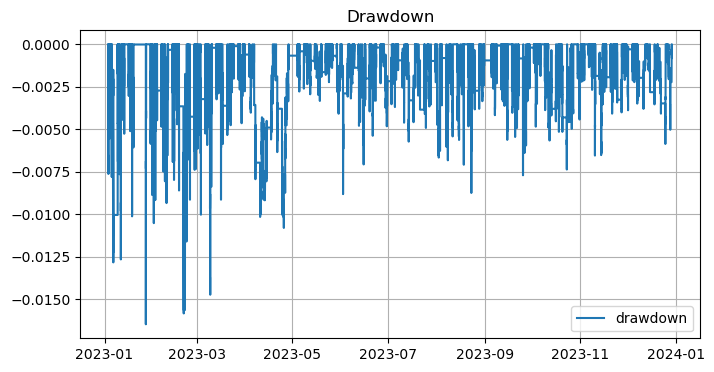

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(optimized_backtest_data["datetime"],
        optimized_backtest_data["drawdown"], label="drawdown")

plt.title('Drawdown')
plt.grid(True)
plt.legend()
plt.show()

## Sharpe Ratio

In [ ]:
trade_return = optimized_backtest_data['Asset'][1:].to_numpy(
) / optimized_backtest_data['Asset'][:-1].to_numpy() - 1
cur_asset_value = optimized_backtest_data['Asset'].iloc[-1]
init_asset_value = optimized_backtest_data['Asset'].iloc[0]

accum_return_rate = (cur_asset_value / init_asset_value - 1) * 100
accum_return_rate

trade_return = np.array(trade_return)  # Ensure trade_return is a NumPy array
# Annual risk-free rate (e.g., government bonds interest is 3%)
risk_free_rate_annual = 0.03
number_of_trades = len(trade_return)
day_of_insample_data = 252  # Number of trading days in sample data
month_of_insample_data = 12  # Number of months in sample data

# Calculate annualized return
annually_return = accum_return_rate / (month_of_insample_data*100) * 12

# Calculate annualized volatility
annually_std = trade_return.std() * np.sqrt(number_of_trades)

# Calculate Sharpe Ratio
sharpe = (annually_return - risk_free_rate_annual) / annually_std

annually_return, annually_std, sharpe

(1.7607099999989835, 0.07757885236229485, 22.30904360271446)